In [18]:
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.CNN import CNNActionValue
from src.evaluate import evaluate
from src.DQN import DQN
# import src.DQN as DQN
from src.Preprocess import preprocess, ImageEnv

In [19]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v3', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

In [20]:
def finetune_bc_with_dqn(
    bc_model_path="bc_model.pt",
    max_steps=300000,
    eval_interval=1000
):
    env = gym.make("CarRacing-v3", continuous=False, render_mode=None)
    state_dim = (4, 84, 84)
    action_dim = 5

    global agent
    agent = DQN(
        state_dim=state_dim,
        action_dim=action_dim,
        epsilon=0.1,
        lr=0.00001
    )

    bc_weights = torch.load(bc_model_path, map_location=agent.device)
    agent.network.load_state_dict(bc_weights)
    agent.target_network.load_state_dict(bc_weights)

    history = {'Step': [], 'AvgReturn': []}
    s, _ = env.reset()
    frames = [preprocess(s)] * 4

    while True:
        state_input = np.stack(frames, axis=0)
        a = agent.act(state_input)
        s_prime, r, terminated, truncated, _ = env.step(a)
        next_frame = preprocess(s_prime)
        next_frames = frames[1:] + [next_frame]

        result = agent.process((state_input, [a], r, np.stack(next_frames, axis=0), float(terminated or truncated)))
        frames = next_frames

        if terminated or truncated:
            s, _ = env.reset()
            frames = [preprocess(s)] * 4

        if agent.total_steps % eval_interval == 0:
            avg_ret = evaluate()
            history['Step'].append(agent.total_steps)
            history['AvgReturn'].append(avg_ret)

            clear_output(wait=True)
            plt.figure(figsize=(8, 5))
            plt.plot(history['Step'], history['AvgReturn'], 'r-')
            plt.xlabel('Step', fontsize=16)
            plt.ylabel('AvgReturn', fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.grid(axis='y')
            plt.show()

            torch.save(agent.network.state_dict(), 'finetuned_dqn.pt')

        if agent.total_steps > max_steps:
            break

    # 최종 그래프 저장
    os.makedirs("plots", exist_ok=True)
    plt.figure(figsize=(8, 5))
    plt.plot(history['Step'], history['AvgReturn'], 'r-')
    plt.xlabel('Step', fontsize=16)
    plt.ylabel('AvgReturn', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y')
    plt.savefig("plots/AvgReturn_Imitation_Reinforcement.png")
    plt.show()

    print("Fine-tuning finished and saved.")

In [ ]:
if __name__ == "__main__":
    finetune_bc_with_dqn()

In [4]:
eval_env = gym.make('CarRacing-v3', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

state_dim = (4, 84, 84)
action_dim = eval_env.action_space.n

agent = DQN.DQN(state_dim, action_dim)
agent.network.load_state_dict(torch.load('finetuned_dqn_84.pt'))  # 저장된 파라미터 로드
agent.network.eval()

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

/opt/conda/envs/imitation_learning_DQN/lib/python3.9/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


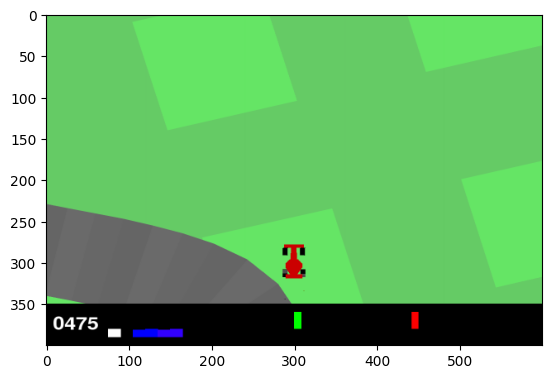

In [5]:
import matplotlib.animation as animation
fig = plt.figure()
ims = []

for frame in frames:
    im = plt.imshow(frame, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

# 애니메이션을 저장
ani.save('car_racing_result_imitation_reinforcement.gif', writer='pillow')

plt.show()